# Micro tutorial on MD with HOOMD package

HOOMD-Blue is a versatile package to run the Molcular Dynamics (MD simulations of particel dynamics, also it is capable to run Monte-Carlo Simulations 
https://hoomd-blue.readthedocs.io/en/latest/index.html


## Molecular dynamics

Molecular dynamics simulations model the movement of interacting particles over time by solving the equations of motion numerically, advancing the state of the system forward by time `dt` on each time step. Molecular dynamics is used to model dynamic, time dependent processes (like fluid flow) or thermodynamic equilibrium states (like gases, liquids and crystals). This tutorial models a system of Lennard-Jones particles in the low dence fluid/high dence gas regimen. 

If you are interested in the basics of the method see the excelent textbook *Frenkel, Daan, and Berend Smit. Understanding molecular simulation: from algorithms to applications. Vol. 1. Elsevier, 2001.*


## Intsallation
If you have installed the Anaconda distribution of Python, than the most easy way is to install he package with conda into specific conda environment, see this page for ditails
https://hoomd-blue.readthedocs.io/en/v3.6.0/installation.html


We will need the following packages

`hoomd`-- the main package 

`gsd` -- separate package to store simulation results in binary files

`fresnel` -- separate package to render simulation box (optional)

These may be intalled simply from the command line (in Linux)

`conda install -c conda-forge hoomd gsd fresnel`

We also need the standard python packages

`jupyter` -- to run notebooks

`numpy`  -- to analyze the data

`matplotlib` -- to plot the results

## Tutorials
If you have time chack out the tutorials provided from the developer
https://github.com/glotzerlab/hoomd-examples

## This tutorial
This tutorial provides basic use case for system of particels that interact with  Lennard-Jones potential. For sufficeintly low density it may be considered as gas or dilute liquid.




# Outline of the Tutorial

1. Importing packages
2. Units and pair potential
3. Constructing the initial state
4. Configuring the simulation
5. Running MD calculations
6. Analysing the data


## 1. Import packages

In [1]:
import hoomd
import matplotlib
import numpy
import time

import gsd.hoomd

%matplotlib inline
matplotlib.style.use('ggplot')

### Function for rendering

You may use the `render` function to get pictures. This code is optional.

In [2]:
import math
import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")

def render(snapshot,radius=0.5):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=radius)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

## 2. Units and pair potential

### Units used in the package

You need to know what system of **units** HOOMD-blue uses so that you can place particles at appropriate separations in the initial configuration.

HOOMD-blue does not adopt any particular real system of **units**. 
Instead, HOOMD-blue uses an *internally self-consistent* system of **units** and is compatible with *many systems of units*.
For example: if you select the units of *meter*, *Joule*, and *kilogram* for length, energy and mass then the units of force will be *Newtons* and velocity will be *meters/second*.
A popular system of units for nano-scale systems is *nanometers*, *kilojoules/mol*, and *atomic mass units*.

In molecular dynamics, the primary **units** are *length*, *energy*, and *mass*.
Other units are derived from these, for example $[\mathrm{pressure}] = \left(\frac{\mathrm{[energy]}}{\mathrm{[length]}^3}\right)$ and $[\mathrm{time}] = \sqrt{\frac{\mathrm{[mass]}\cdot\mathrm{[length]}^2}{\mathrm{[energy]}}}$.
Some quantities involve physical constants as well, such as *charge* which has units of $\sqrt{4\pi\epsilon_0\cdot\mathrm{[length]}\cdot\mathrm{[energy]}}$ (where $\epsilon_0$ is the permittivity of free space), and thermal energy $kT$ (where *k* is Boltzmann's constant).
HOOMD-blue never uses the temperature *T* directly. Instead it always appears indirectly in the value $kT$ which has units of energy.

HOOMD-blue does not perform unit conversions.
You provide all parameters in this system of units and all outputs will be given in these units.
The documentation for each property and parameter will list the units.
For the parameters set in this tutorial so far, the integrator's `dt` is in time units, the pair potentials `epsilon` is in energy units while `sigma` and `r_cut` are in length units.

You can interpret these values in the nano-scale units mentioned previously:

Unit | Value
--- | --- 
**\[length\]** | nanometer
**\[energy\]** | kilojoules/mol
**\[mass\]** | atomic mass unit
\[time\] | picoseconds
\[volume\] | cubic nanometers
\[velocity\] | nm/picosecond
\[momentum\] | amu nm/picosecond
\[acceleration\] | nm/picosecond^2
\[force\] | kilojoules/mol/nm
\[pressure\] | kilojoules/mol/nm^3
*k* | 0.0083144626181532 kJ/mol/Kelvin


HOOMD-blue provides a number of forces that are derived from **potential energy.** **Pair potentials** define the functional form of the potential energy between a single pair of particles given their separation distance *r*.
The Lennard-Jones potential is: $$V_{\mathrm{LJ}}(r) = 4 \varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]$$

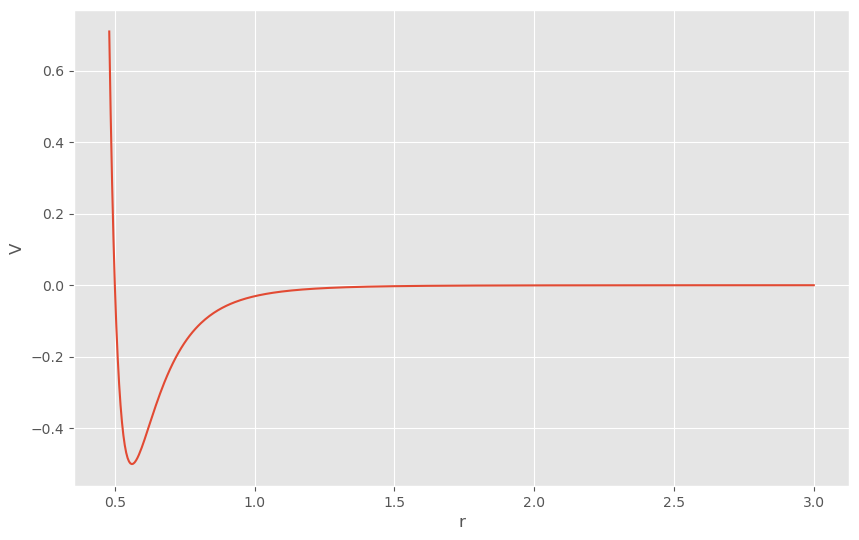

In [3]:
sigma = 0.5
epsilon = 0.5
r = numpy.linspace(0.48, 3.0, 500)

V_lj = 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(r, V_lj)
ax.set_xlabel('r')
ax.set_ylabel('V')
fig

**Note** This potential is already zero at ~1.5 length units, while the steep repultion starts at 0.5, which may be considered as an atomic size value.  
*Is it radius or diameter?*

## 3. Constructing the initial state

### Initialize positions on lattice
Here we construct the initial state in which all paricles are located in the lattice with specified `spacing`.



In [4]:
# Initialize the cubuc box initially
M = 20
N_particles = M**3
#
#
spacing = 6.0
#
L = M * spacing
x = numpy.linspace(-L / 2, L / 2, M, endpoint=False) 
#
position = []
for i in range(M):
    for j in range(M):
        for k in range(M):
            position_item = [x[i], x[j], x[k]]
            position.append(position_item)
#
#
# Generate the snapshot (The state of the system)
snapshot_init = gsd.hoomd.Snapshot()
snapshot_init.particles.N = N_particles
snapshot_init.particles.position = position[0:N_particles]
snapshot_init.particles.typeid = [0] * N_particles
snapshot_init.configuration.box = [L, L, L, 0, 0, 0]
#
# Here we name our paricles with letter 'A'
snapshot_init.particles.types = ['A']

Have a look on the initial state

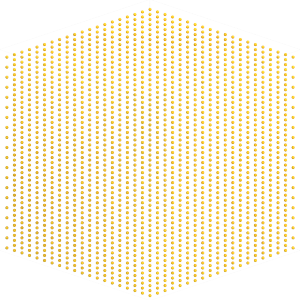

In [5]:
render(snapshot_init, radius=1.0)

### Initialize random velocities

Choose initial velicities randomly somehow. 

In [6]:
# Choose initially random velocities
v_x_max =  2.0
v_x_min = -2.0
#
velocity = []
for i in range(N_particles):
    velocity.append(numpy.random.uniform(v_x_min, v_x_max, size=3)) # Uniformly distributed random values

snapshot_init.particles.velocity = velocity[0:N_particles]


*What type of distribution will have the velocity modules?*

### Save the initial configuration

In [7]:
# Save the initial state (use mode='xb' -- for overwrite protection)
with gsd.hoomd.open(name='snapshot_init.gsd', mode='wb') as f: 
    f.append(snapshot_init)

## 4. Configuring the simulation

Here we will inialize the object `sim` -- which is a simulation object.

It contains the state (describing the particle positions and velocities at the beggining), together with the information on how we want to integrate the equations of motion. 

#### 4.1 Initializing the simulation

In [26]:
cpu = hoomd.device.CPU() # device to use, 
# if you are lucky to install the GPU variant than you may use faster GPU device
#
# Now we create a master object for MD simulation
sim = hoomd.Simulation(device=cpu, seed=1)
# create state from the prepared initial structure 
sim.create_state_from_gsd(filename='snapshot_init.gsd') #(from file)
# or sim.create_state_from_snapshot(snapshot_init) # alternatively from structure 

#### 4.2  Iniializing the potential

In [27]:
# Same values for sigma and epsilon as above, but you may test different
sigma   = 0.5  
epsilon = 0.5 
r_cut   = 2.5 # cut-off distance to truncate the potential 
cell = hoomd.md.nlist.Cell(buffer=4.0) # The neighbour list scheme 
                                       # (needed to claculate forces only with neighbour parucles)
#
lj = hoomd.md.pair.LJ(nlist=cell) # Lennard-Jones potential
lj.params[('A', 'A')] = dict(epsilon=epsilon, sigma=sigma)
lj.r_cut[('A', 'A')] = r_cut


#### 4.3 Iniializing the integrator (method for updating the state)

In [28]:
dt_value = 0.001
integrator = hoomd.md.Integrator(dt = dt_value)
#
# Add information on potential
integrator.forces.append(lj)
#
# Choosing the integrator to generate states in NVE ensemble (standard MD)
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
integrator.methods.append(nve)#nve
#
# Put in into the sim object
sim.operations.integrator = integrator

#### 4.4 Specify the filename and the writer to write trajctiory

In [29]:
########################################
# Here we specify the writer to write down the states during the simulation
# dynamic=[''] -- list of properties that will be saved
# Each step_freq will be write down (use mode='xb' -- for overwrite protection)
step_freq = 100 
file_name = 'trajectory.gsd'
gsd_writer = hoomd.write.GSD(filename=file_name,
                             trigger=hoomd.trigger.Periodic(step_freq),
                             mode='wb',
                             dynamic=['property','momentum'])
sim.operations.writers.append(gsd_writer)


#### 4.4 Add the thermodynamic properties to be computed as also saved in the trajectory file

In [30]:
# logger is used logging logs
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)
#
logger = hoomd.logging.Logger()
logger.add(thermodynamic_properties)
gsd_writer.log = logger


**Test initial values of the kinetic and potential energy**

In [31]:
# Y0u may see all stored values in the (thermodynamic_properties.loggables)
#
sim.run(0) # calculate the values 
print('Kinetic energy =', thermodynamic_properties.kinetic_energy)
print('Potential energy =', thermodynamic_properties.potential_energy)


Kinetic energy = 16026.46646966416
Potential energy = 0.0


## 5. Running MD calculations

Run the MD simulation. Number of steps needed for system to converge to equilibrium depends on the system and should be selected empirically

In [32]:
num_of_steps = 100000 # 
#
start_time = time.time()
sim.run(num_of_steps)
print('MD calculations took {} sec'.format(time.time() - start_time))


MD calculations took 73.6458523273468 sec


Have a look on the final state

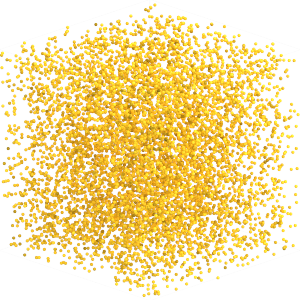

In [33]:
snapshot_final= sim.state.get_snapshot()
render(snapshot_final, radius=1.0)


In [34]:
print('Kinetic energy =', thermodynamic_properties.kinetic_energy)
print('Potential energy =', thermodynamic_properties.potential_energy)

Kinetic energy = 16039.082709466662
Potential energy = -12.767739478911599


# Analyse the trajectory



Load trajectory

In [35]:
traj = gsd.hoomd.open('trajectory.gsd')
len(traj)

1000

Calculate the velocity distributions at each saved state

In [36]:
bin_vals = numpy.arange(0,6, 0.45)

hist_list       = []
kin_energy_list = []
# loop through frames in the trajectory
for frame in traj:
    vel_vals = numpy.linalg.norm(frame.particles.velocity, axis=1)# get the velocties modules
    hist = numpy.histogram(vel_vals,bin_vals)
    hist_list.append(hist)
    #print(frame.particles.velocity[0])#vel_vals.mean())
    kin_energy = (frame.particles.velocity**2).sum()/2/N_particles
    kin_energy_list.append(kin_energy)
    


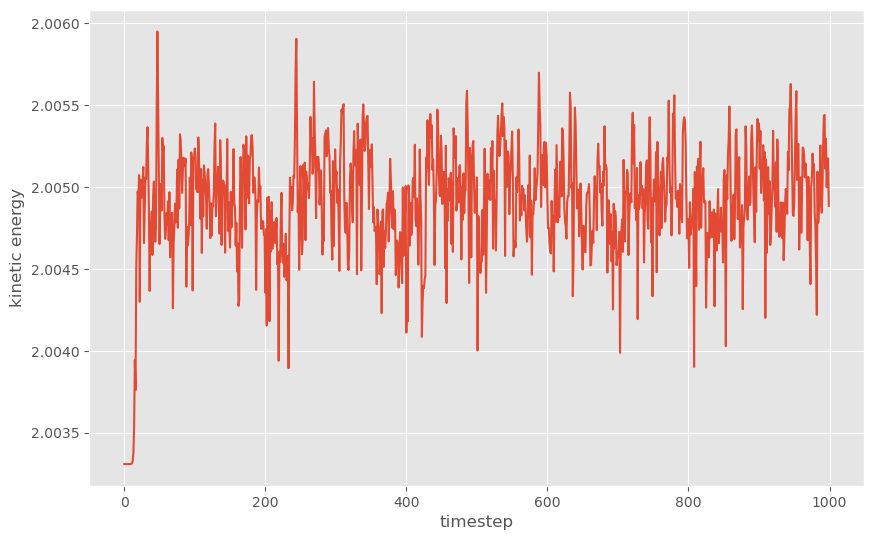

In [37]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
    
ax.plot(kin_energy_list)

ax.set_xlabel('timestep')
ax.set_ylabel('kinetic energy')
fig

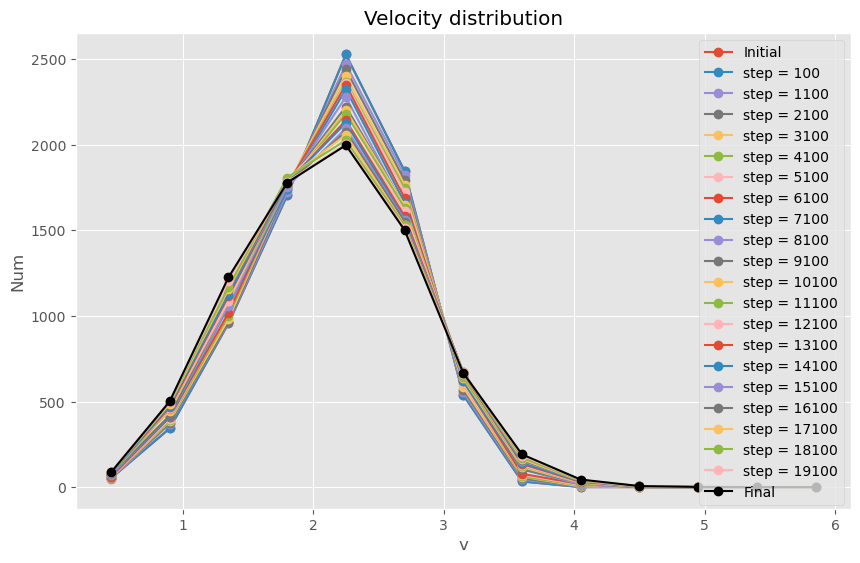

In [38]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
vel_vals = numpy.linalg.norm(snapshot_init.particles.velocity, axis=1)
hist_start = numpy.histogram(vel_vals,bin_vals)

ax.plot(bin_vals[1:], hist_start[0], '-o', label='Initial')


for ind, hist in enumerate(hist_list[2:]):
    if ((ind % 50) == 5) and (ind <= 3000):
        ax.plot(bin_vals[1:], hist[0], '-o', label='step = {}'.format(20*(ind)))
    

vel_vals = numpy.linalg.norm(snapshot_final.particles.velocity, axis=1)
hist_final = numpy.histogram(vel_vals,bin_vals)

ax.plot(bin_vals[1:], hist_final[0], '-ok', label='Final')
    
ax.set_xlabel('v')
ax.set_ylabel('Num')
ax.set_title('Velocity distribution')
ax.set_title('Velocity distribution')
ax.legend()

#ax.set_ylim(0,400)

fig    

In [41]:
final = (snapshot_final.particles.velocity**2).sum()/2
init = (snapshot_init.particles.velocity**2).sum()/2
print('Kinetic energy\nInitial {} and final {}'.format(init, final))

Kinetic energy
Initial 16026.466796875 and final 16039.082709466635


In [42]:
timestep = []
kinetic_energy = []
potential_energy = []

for frame in traj:
    timestep.append(frame.configuration.step)
    potential_energy.append(
        frame.log['md/compute/ThermodynamicQuantities/potential_energy'][0])
    kinetic_energy.append(
        frame.log['md/compute/ThermodynamicQuantities/kinetic_energy'][0])
    

Look at energy conservation

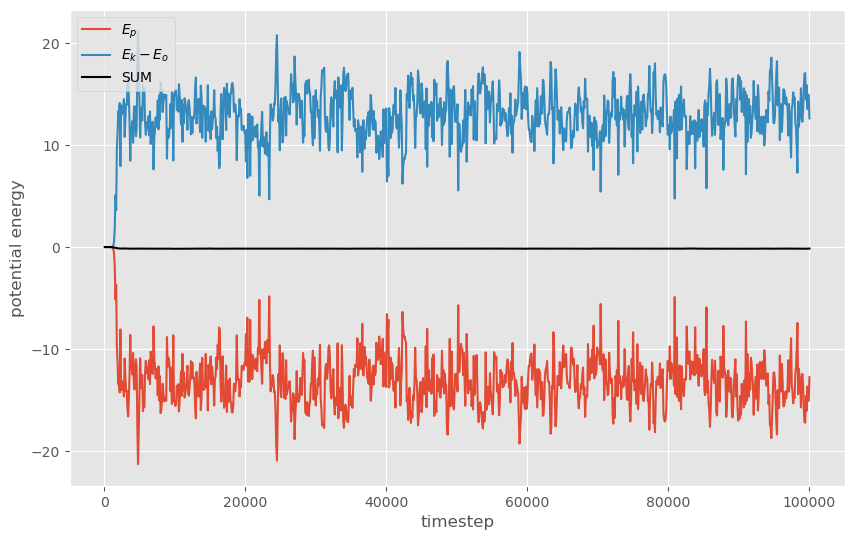

In [61]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(timestep, potential_energy, label='$E_p$')
ax.plot(timestep, numpy.array(kinetic_energy) -init, label='$E_k - E_o$')
ax.plot(timestep, numpy.array(kinetic_energy)-init + numpy.array(potential_energy), '-k', label='SUM')
ax.set_xlabel('timestep')
ax.set_ylabel('potential energy')
ax.legend()
fig